# DDoS Attack detection using Deep Learning

**Mount CICIDS2017 dataset from google drive**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the CICIDS2017 dataset (Wednesday working hours)

**Import Numpy ,Pandas and Load dataset**

In [27]:
import pandas as pd
import numpy as np
path = "/content/drive/My Drive/data/Wednesday-workingHours.pcap_ISCX.csv"
df4 = pd.read_csv(path)



**Having a look at the dataset stored in dataframe df4**

In [28]:
df4.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,6,6,6.000000,0.000000,3.132505e+02,52.208416,38308.000000,0.000000,38308,38308,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,0,20,20,26.104208,26.104208,6,6,6.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,9.000000,6.000000,6.000000,20,0,0,0,0,0,0,1,6,1,6,255,946,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,163,0,65.200000,89.278777,1.039666e+06,33402.922760,31.933333,25.510409,73,0,479,47.900000,38.942836,109,1,401,100.250000,101.736178,237,3,0,0,0,0,368,176,22964.509390,10438.413360,0,163,29.294118,56.529599,3195.595588,0,0,0,1,0,0,0,0,0,31.125000,15.636364,65.200000,368,0,0,0,0,0,0,11,172,5,326,29200,260,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,1575,0,525.000000,813.326503,5.753425e+06,14611.872150,73.000000,204.960972,810,1,1095,121.666667,298.746130,915,1,995,199.000000,345.535092,810,3,0,0,0,0,336,208,9132.420091,5479.452055,0,1575,370.588235,671.751541,451250.132400,0,0,0,1,0,0,0,0,0,393.750000,315.000000,525.000000,336,0,0,0,0,0,0,10,3150,6,3150,29200,2081,3,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058824,425.778474,3069,0,555.000000,977.480342,6.650007e+05,1907.141918,543.071429,2519.931377,13391,0,15206,950.375000,3322.417812,13391,2,15112,1373.818182,4176.449588,13961,3,0,0,0,0,560,388,1117.979745,789.162173,0,3069,337.066667,704.654082,496537.374700,0,0,0,1,0,0,0,0,0,348.689655,203.058824,555.000000,560,0,0,0,0,0,0,17,3452,12,6660,29200,0,10,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,1576,0,525.333333,813.842901,5.771062e+06,13736.263740,78.000000,207.000929,794,1,1092,136.500000,313.850738,910,1,1015,203.000000,333.240154,794,3,0,0,0,0,304,208,8241.758242,5494.505495,0,1576,393.875000,704.585067,496440.116700,0,0,0,1,0,0,0,0,0,420.133333,350.000000,525.333333,304,0,0,0,0,0,0,9,3150,6,3152,29200,2081,2,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


**Check for null values**

In [29]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             692703 non-null  int64  
 1    Flow Duration                692703 non-null  int64  
 2    Total Fwd Packets            692703 non-null  int64  
 3    Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets   692703 non-null  int64  
 5    Total Length of Bwd Packets  692703 non-null  int64  
 6    Fwd Packet Length Max        692703 non-null  int64  
 7    Fwd Packet Length Min        692703 non-null  int64  
 8    Fwd Packet Length Mean       692703 non-null  float64
 9    Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max         692703 non-null  int64  
 11   Bwd Packet Length Min        692703 non-null  int64  
 12   Bwd Packet Length Mean       692703 non-nul

**Convert the np.inf values to null and remove those data points**

In [30]:

df4 = df4.replace([np.inf, -np.inf], np.nan)
df4 = df4.dropna()

In [31]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691406 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             691406 non-null  int64  
 1    Flow Duration                691406 non-null  int64  
 2    Total Fwd Packets            691406 non-null  int64  
 3    Total Backward Packets       691406 non-null  int64  
 4   Total Length of Fwd Packets   691406 non-null  int64  
 5    Total Length of Bwd Packets  691406 non-null  int64  
 6    Fwd Packet Length Max        691406 non-null  int64  
 7    Fwd Packet Length Min        691406 non-null  int64  
 8    Fwd Packet Length Mean       691406 non-null  float64
 9    Fwd Packet Length Std        691406 non-null  float64
 10  Bwd Packet Length Max         691406 non-null  int64  
 11   Bwd Packet Length Min        691406 non-null  int64  
 12   Bwd Packet Length Mean       691406 non-nul

**Changing the labels from (Benign and DDoS attack) to binary (0,1)**

In [32]:
#DF4
#making output binary:
df4 = df4.rename(columns={" Label": "Label"})
df4.loc[df4. Label == "BENIGN", "Label"] = 0.0
df4.loc[df4. Label != 0, "Label"] = 1.0


**Check for imbalance in the dataset**

Class 0: 439683
Class 1: 251723
Proportion: 1.75 : 1


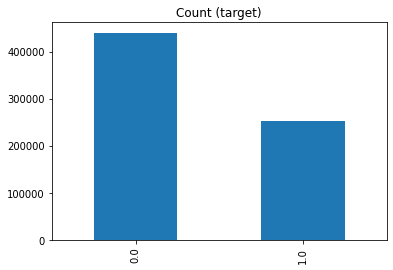

In [33]:

target_count = df4.Label.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

**Random Undersampling**





Random under-sampling:
1.0    251723
0.0    251723
Name: Label, dtype: int64


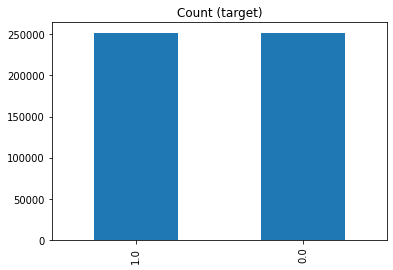

In [34]:
#random undersampling
count_class_0, count_class_1 = df4.Label.value_counts()

# Divide by class
df4_class_0 = df4[df4['Label'] == 0]
df4_class_1 = df4[df4['Label'] == 1]

df4_class_0_under = df4_class_0.sample(count_class_1)
df4_mod = pd.concat([df4_class_0_under, df4_class_1], axis=0)

print('Random under-sampling:')
print(df4_mod.Label.value_counts())

df4_mod.Label.value_counts().plot(kind='bar', title='Count (target)')

**Dropping the socket features and assgning to numpy arrays**

In [35]:
df4_mod.drop([" Destination Port"],axis = 1, inplace = True) 
X=df4_mod.iloc[:, :-1 ].to_numpy()
y = df4_mod.iloc[:,-1].to_numpy()
from sklearn.preprocessing import LabelEncoder
labelencoder= LabelEncoder()
y = labelencoder.fit_transform(y)

**Splitting the dataset into train and test data**

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

from sklearn.preprocessing import MinMaxScaler
scale_X= MinMaxScaler()
X_train= scale_X.fit_transform(X_train)
X_test= scale_X.transform(X_test)


**A look at the shape of training and testing dataset**

In [37]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(402756, 77)
(402756,)
(100690, 77)
(100690,)


**Computing feature importance using random forest for efficient feature selection:**

In [38]:
#random forest:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
np.random.seed(1)

trees = 100

#RandomForestClassifier(n_estimators=trees,max_features=max_feat,max_depth=max_depth,min_samples_split= min_sample, random_state=0,n_jobs=-1)


sel = SelectFromModel(RandomForestClassifier(n_estimators=trees, random_state=0,n_jobs=-1), threshold= 0.005)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
 

**Show which features are selected**

In [39]:
frame = pd.DataFrame(X_train,index=X_train[:,0])
selected_feat= frame.columns[(sel.get_support())]
n =len(selected_feat)

In [40]:
print("Selected number of features: ", n)
print(selected_feat)



Selected number of features:  38
Int64Index([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 20, 21, 22,
            33, 34, 36, 37, 38, 39, 40, 41, 45, 51, 52, 53, 54, 61, 62, 63, 65,
            66, 73, 75, 76],
           dtype='int64')


**Taking only the selected features**

In [41]:
features = X_train[:, selected_feat]
X_train = features
X_test = X_test[:, selected_feat]

**Feature importance bar chart**

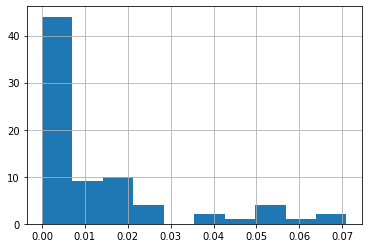

In [42]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

**Importance of each features**

In [43]:
sel.estimator_.feature_importances_

array([6.53902210e-03, 9.27637269e-03, 1.42785802e-02, 2.49290111e-02,
       3.05780531e-03, 1.57362545e-02, 1.28188155e-02, 1.96219640e-02,
       8.01008451e-03, 5.42994634e-02, 1.38205035e-02, 5.12200650e-02,
       5.32767764e-02, 8.61719049e-04, 7.64539559e-03, 1.45589663e-02,
       3.42400907e-03, 4.99237397e-03, 2.80087812e-03, 4.25514802e-03,
       8.00786345e-03, 1.99758308e-02, 1.50694980e-02, 4.71372764e-03,
       7.95750316e-04, 2.17408301e-03, 1.34888557e-03, 2.30184345e-03,
       2.10352392e-03, 5.12302448e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.63066704e-02, 1.93828385e-02, 3.39342787e-03,
       6.88042628e-03, 6.80798534e-02, 4.28257026e-02, 7.09944784e-02,
       5.23219150e-02, 2.53266189e-02, 3.70257598e-03, 7.76876103e-04,
       0.00000000e+00, 5.28798371e-03, 2.88246073e-03, 2.61058958e-03,
       0.00000000e+00, 1.08978541e-06, 4.66751944e-03, 4.06367010e-02,
       2.56978825e-02, 6.36161391e-02, 1.25995135e-02, 0.00000000e+00,
      

**Designing and training the MLP model:**

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
def build_classifier():
    classifier=Sequential()
    classifier.add(Dense(15, activation='relu', input_shape=(n, )))
    #classifier.add(Dropout(p =0.1))
    classifier.add(Dense(10, activation='relu'))
    #classifier.add(Dropout(p= 0.1))
    classifier.add(Dense(25, activation='relu'))
    #classifier.add(Dropout(p=0.1))
    classifier.add(Dense(25, activation='relu'))
    classifier.add(Dense(10, activation='relu'))
    #classifier.add(Dropout(p=0.1))
    classifier.add(Dense(1, activation='sigmoid' ))
    classifier.compile(optimizer='adam' , loss='binary_crossentropy', metrics=['accuracy'])
    return classifier
    #Kfold:

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
classifier = KerasClassifier(build_fn = build_classifier, batch_size=10, nb_epoch=30)

**K(=10) fold cross validation:**

In [45]:
accuracies =  cross_val_score(estimator=classifier, X=X_train, y=y_train,cv=10, n_jobs=-1)
mean=accuracies.mean()
dev=accuracies.std()

In [46]:
print ("accuracies of each fold:")
i=1
for accuracy in accuracies:
  print("Accuracy in ",i,"th fold: ",accuracy)
  i=i+1

print("Mean accuracy in K fold cross validation: ", mean)
print("Std deviation in K fold cross validation: ", dev)

accuracies of each fold:
Accuracy in  1 th fold:  0.980087399482727
Accuracy in  2 th fold:  0.9790446162223816
Accuracy in  3 th fold:  0.9778279662132263
Accuracy in  4 th fold:  0.9820488691329956
Accuracy in  5 th fold:  0.9738305807113647
Accuracy in  6 th fold:  0.9826447367668152
Accuracy in  7 th fold:  0.9800620675086975
Accuracy in  8 th fold:  0.9825201630592346
Accuracy in  9 th fold:  0.9798882603645325
Accuracy in  10 th fold:  0.9777529239654541
Mean accuracy in K fold cross validation:  0.9795707583427429
Std deviation in K fold cross validation:  0.0025390310340867896


**Training the ANN model**

In [47]:
hist = classifier.fit(X_train ,y_train, batch_size=57 ,epochs=100, validation_split= 0.2)

Epoch 1/100
5653/5653 [==============================] - 17s 3ms/step - loss: 0.1826 - accuracy: 0.9294 - val_loss: 0.0772 - val_accuracy: 0.9780
Epoch 2/100
5653/5653 [==============================] - 16s 3ms/step - loss: 0.0685 - accuracy: 0.9762 - val_loss: 0.0572 - val_accuracy: 0.9807
Epoch 3/100
5653/5653 [==============================] - 16s 3ms/step - loss: 0.0593 - accuracy: 0.9797 - val_loss: 0.0534 - val_accuracy: 0.9821
Epoch 4/100
5653/5653 [==============================] - 17s 3ms/step - loss: 0.0551 - accuracy: 0.9818 - val_loss: 0.0504 - val_accuracy: 0.9825
Epoch 5/100
5653/5653 [==============================] - 16s 3ms/step - loss: 0.0537 - accuracy: 0.9824 - val_loss: 0.0532 - val_accuracy: 0.9881
Epoch 6/100
5653/5653 [==============================] - 17s 3ms/step - loss: 0.0499 - accuracy: 0.9835 - val_loss: 0.0473 - val_accuracy: 0.9836
Epoch 7/100
5653/5653 [==============================] - 17s 3ms/step - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0424 -

**Performance measurement function**

In [48]:
def perf_measure(y_actual, y_pred):
    global SENSITIVITY
    global SPECIFICITY
    global PRECISION
    global NEGATIVE_PREDICTIVE_VALUE
    global FALSE_NEGATIVE_RATE
    global FALSE_POSITIVE_RATE
    global FALSE_DISCOVERY_RATE
    global FALSE_OMISSION_RATE
    global ACCURACY
    global F1_SCORE
    global Iteration
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(y_pred)): 
        #print('actual',y_actual[i])
        #print('predicted', y_pred[i])
        if y_actual[i]==y_pred[i]==1.:
            #print('TP')
            TP += 1
        if y_pred[i]==1. and y_actual[i]!=y_pred[i]:
            #print('FP')
            FP += 1
        if y_actual[i]==y_pred[i]==0.:
            #print('TN')
            TN += 1
        if y_pred[i]==0. and y_actual[i]!=y_pred[i]:
            FN += 1
            #print("FN")
    
    #SENSITIVITY += TP/(TP + FN)
    #SPECIFICITY += TN/(TN + FP)
    #PRECISION += TP/(TP + FP)
    #NEGATIVE_PREDICTIVE_VALUE += TN/(TN + FN)
    #FALSE_NEGATIVE_RATE += FN/(FN + TP)
    #FALSE_POSITIVE_RATE += FP/(FP + TN)
    #FALSE_DISCOVERY_RATE += FP/(FP + TP)
    #FALSE_OMISSION_RATE += FN/(FN + TN)
    #ACCURACY += (TP + TN)/(TP + TN + FP + FN)
    #F1_SCORE += 2*TP/(2*TP + FP + FN)
    #Iteration = Iteration + 1
    return (TP, TN, FP, FN)

**Prediction results with this model on TEST SET:**

In [49]:

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
pred_test = classifier.predict(X_test)
pred_test  = [1 if y>=0.5 else 0 for y in pred_test] #Threshold
#print(classification_report(y_test ,pred_test ))
#print('Confusion Matrix: \n',confusion_matrix(y_test,pred_test))
#print()
#print('Accuracy: ', accuracy_score(y_test,pred_test))
#print()



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**Confusion Matrix**

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    


**Confusion Matrix for RF-MLP model**

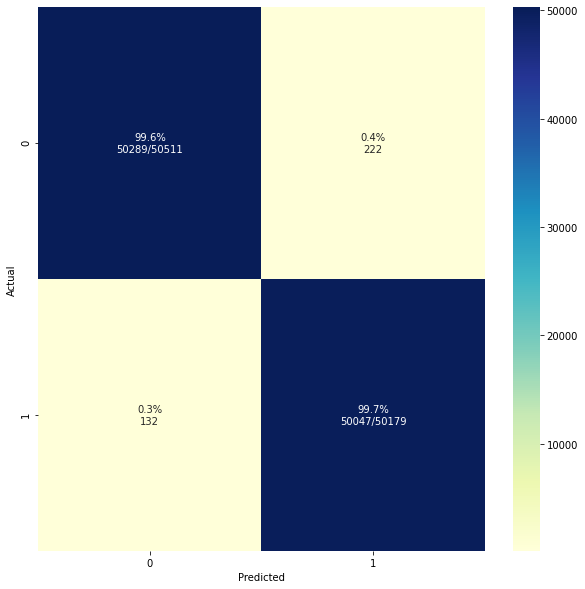

In [51]:
plot_cm(y_test, pred_test)

**ROC curve generation**

TP:  100155
TN:  100504
FP:  518
FN:  203


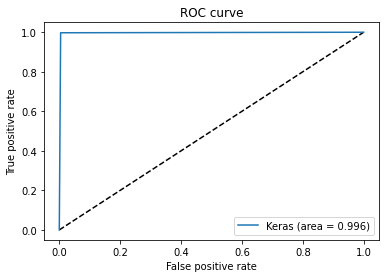

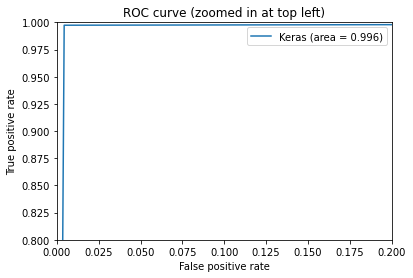

In [52]:

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_new = np.rint(pred_test)
(tp, tn, fp, fn) = perf_measure(y_test, y_new)
TP = TP + tp
FP = FP + fp
FN = FN + fn
TN = TN + tn
cvscores.append(scores[1]*100)
i = i + 1

#y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred_test)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# Zoom in view of the upper left corner.
plt.figure(4)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
#print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("TP: ",TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

plt.show()

**CNN Model**

3147/3147 [==============================] - 6s 2ms/step - loss: 0.0161 - accuracy: 0.9955

accuracy: 99.55%
99.55% (+/- 0.00%)
TP:  50129
TN:  50112
FP:  399
FN:  50


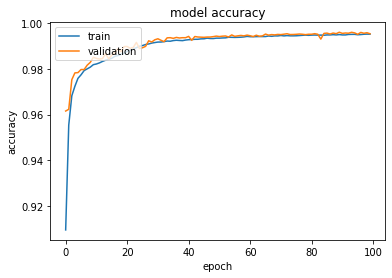

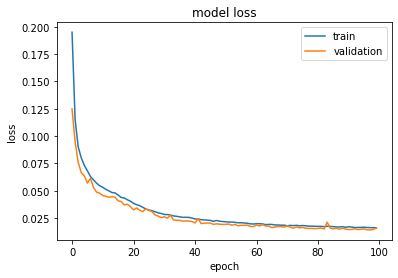

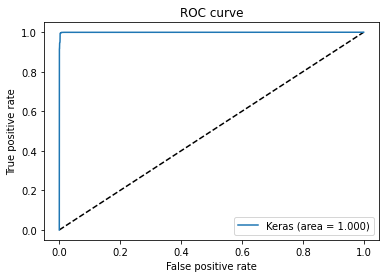

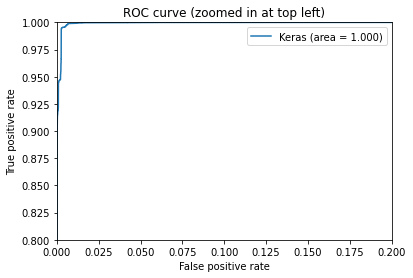

Average SENSITIVITY: 0.999003567229319
Average SPECIFICITY: 0.9921007305339431
Average PRECISION: 0.9921033882203927
Average NEGATIVE_PREDICTIVE_VALUE: 0.9990032295363024
Average FALSE_NEGATIVE_RATE: 0.0009964327706809622
Average FALSE_POSITIVE_RATE: 0.007899269466056898
Average FALSE_DISCOVERY_RATE: 0.007896611779607347
Average FALSE_OMISSION_RATE: 0.0009967704636976197
Average ACCURACY: 0.9955407686959976
Average F1_SCORE: 0.9955415214433952


In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#train, test, train_labels, test_labels = train_test_split(reduced_data, labels, test_size=0.20, random_state=7)

TP = 0
TN = 0
FP = 0
FN = 0

#print(reduced_data[0])
seed = 7
# define 10-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
i = 0
#for train, test in kfold.split(reduced_data, labels):
#X_train = np.expand_dims(X_train, axis=2)
#X_test = np.expand_dims(X_test, axis=2)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(n,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(256, activation='relu'))
#model.add(Dense(20, activation='relu'))
#model.add(Dense(80, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nb_epoch = 3
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=512, verbose=0)


f = plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.show()
# summarize history for loss
g = plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.show()


# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred_y = model.predict(X_test)
y_new = np.rint(pred_y)
(tp, tn, fp, fn) = perf_measure(y_test, y_new)
TP = TP + tp
FP = FP + fp
FN = FN + fn
TN = TN + tn
cvscores.append(scores[1]*100)
i = i + 1

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# Zoom in view of the upper left corner.
plt.figure(4)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("TP: ",TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

plt.show()

SENSITIVITY = TP/(TP + FN)
SPECIFICITY = TN/(TN + FP)
PRECISION = TP/(TP + FP)
NEGATIVE_PREDICTIVE_VALUE = TN/(TN + FN)
FALSE_NEGATIVE_RATE = FN/(FN + TP)
FALSE_POSITIVE_RATE = FP/(FP + TN)
FALSE_DISCOVERY_RATE = FP/(FP + TP)
FALSE_OMISSION_RATE = FN/(FN + TN)
ACCURACY = (TP + TN)/(TP + TN + FP + FN)
F1_SCORE = 2*TP/(2*TP + FP + FN)
Iteration = 1
print('Average SENSITIVITY: '+str(SENSITIVITY/Iteration))
print('Average SPECIFICITY: '+str(SPECIFICITY/Iteration))
print('Average PRECISION: '+str(PRECISION/Iteration))
print('Average NEGATIVE_PREDICTIVE_VALUE: '+str(NEGATIVE_PREDICTIVE_VALUE/Iteration))
print('Average FALSE_NEGATIVE_RATE: '+str(FALSE_NEGATIVE_RATE/Iteration))
print('Average FALSE_POSITIVE_RATE: '+str(FALSE_POSITIVE_RATE/Iteration))
print('Average FALSE_DISCOVERY_RATE: '+str(FALSE_DISCOVERY_RATE/Iteration))
print('Average FALSE_OMISSION_RATE: '+str(FALSE_OMISSION_RATE/Iteration))
print('Average ACCURACY: '+str(ACCURACY/Iteration))

print('Average F1_SCORE: '+str(F1_SCORE/Iteration))

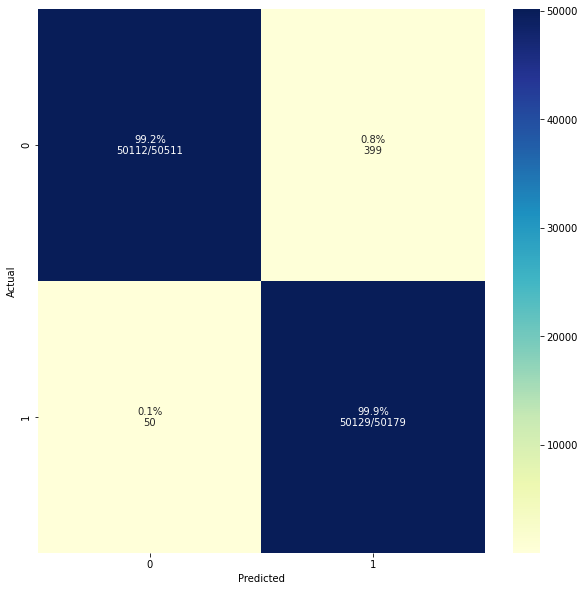

In [54]:
plot_cm(y_test, y_new)